This notebook is created to calculate metrics related to `WestBoro Photonic` images.

`Descriptive statistics`, `RMS contrast`, ` Amplitude spectra`

Results has been saved as `csv` files in `spatial-paper-dir`. 

In [29]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from scipy.stats import linregress
import csv

In [ ]:
# Set default font properties
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 10

In [14]:
# working directory path
root_dir = r'\\kfs\tscn-dropbox\scenes\data'

wp_derivatives_dir = f'{root_dir}\\derivatives\wp_derivatives'

# The spatial analysis directory path
spatial_paper_dir = f'{root_dir}\\results\spatial-paper'

# The metadata directory path
metadata_dir = f'{root_dir}\\metadata'

# An example of NPZ files

In [19]:
# Load the npz file with timestamp 20230616T1400

WP_derivatve_example = np.load(
    f'{wp_derivatives_dir}\\1013_20230616\\1013_20230616T1400\wp690_20230616T1400.npz'
)

In [20]:
# Iterate over the arrays and print keys

for key in WP_derivatve_example.keys():
    print(key)

lcone
mcone
scone
rhodopic
iprgc
luminance
trix
triz
stdred
stdgreen
stdblue


In [21]:
# Iterate over the items (11 keys and that each has a 2D numpy array as an item)

for item in WP_derivatve_example.items():
    print('Data for key:', item[0])
    print(item[1])

Data for key: lcone
[[0.10880166 0.11003561 0.10941134 ... 0.098504   0.10003075        nan]
 [0.11116862 0.1097106  0.10919742 ... 0.09876389 0.09934007        nan]
 [0.11256282 0.10939774 0.10814832 ... 0.09883082 0.09879532        nan]
 ...
 [0.02981747 0.02977522 0.02897558 ... 0.01524529 0.01547262        nan]
 [0.02945814 0.03102202 0.03040862 ... 0.01487426 0.01546189        nan]
 [0.02905997 0.03043864 0.03080934 ... 0.01576324 0.01637148        nan]]
Data for key: mcone
[[0.08378313 0.08638547 0.08374787 ... 0.08150893 0.07756776 0.07937648]
 [0.08400431 0.08756662 0.08503443 ... 0.07805045 0.07791258 0.07649303]
 [0.08586047 0.08548401 0.08538244 ... 0.07860088 0.07663406 0.07856327]
 ...
 [0.0228907  0.02330795 0.0226477  ... 0.01361629 0.01132311 0.01281938]
 [0.0216939  0.02389316 0.02232106 ... 0.01229639 0.0119183  0.01184708]
 [0.02284644 0.02482153 0.02384674 ... 0.01190283 0.0125393  0.01162816]]
Data for key: scone
[[       nan        nan        nan ...        nan   

In [22]:
# The 2D numpy array of key {iprgc}

WP_derivatve_example_iprgc = WP_derivatve_example['iprgc']

In [23]:
# Dimensios of 2D numpy arrays and total pixels in each channel

num_rows, num_cols = WP_derivatve_example_iprgc.shape
num_values = WP_derivatve_example_iprgc.size

print( f'number of rows = {num_rows}')
print( f'number of columns =  {num_cols}')
print( f'number of total pixels = {num_values}')

number of rows = 2712
number of columns =  3388
number of total pixels = 9188256


# Create a dataframe to itterate over all wp derivative files (npz)

In [24]:

# Initialize an empty list to store file names and paths
file_data = []

# Walk through the directory
for dirpath, dirnames, filenames in os.walk(wp_derivatives_dir):
    for file in filenames:
        if file.endswith('.npz'):  # Only select npz files
            full_path = os.path.join(dirpath, file)
            # Extract the last 13 characters before the '.npz' extension as the timestamp
            timestamp = file[-17:-4]
            # Append a dictionary with file name, full path, and timestamp
            file_data.append({
                'file_name': file,
                'file_path': full_path,
                'timestamp': timestamp
            })

# Create a DataFrame from the list
wp_derivatives_df = pd.DataFrame(file_data)

In [25]:

wp_derivatives_df.head()

,file_name,file_path,timestamp
0,wp690_20230208T0800.npz,\\kfs\tscn-dropbox\scenes\data\derivatives\wp_...,20230208T0800
1,wp690_20230208T0900.npz,\\kfs\tscn-dropbox\scenes\data\derivatives\wp_...,20230208T0900
2,wp690_20230208T0930.npz,\\kfs\tscn-dropbox\scenes\data\derivatives\wp_...,20230208T0930
3,wp690_20230208T1000.npz,\\kfs\tscn-dropbox\scenes\data\derivatives\wp_...,20230208T1000
4,wp690_20230208T1030.npz,\\kfs\tscn-dropbox\scenes\data\derivatives\wp_...,20230208T1030


In [79]:
num_rows = wp_derivatives_df.shape[0]
print(f'number of westBoro measurements = {num_rows}')

number of westBoro measurements = 721


In [77]:
# Define the new names for the first five keys

new_key_names = ["L cones", "M cones", "S cones", "Rods", "Melanopsin"]

In [28]:
# Calculate `invalid_pixels`, `overexposed_pixels` and `average_radiances` values for five first key of all measurements

# Initialize an empty DataFrame for the results
wp_derivatives_alpha_opics_values_df = pd.DataFrame()

# Iterate over each row in the original DataFrame
for index, row in wp_derivatives_df.iterrows():
    file_path = row['file_path']  # Get the file path
    file_name = row['file_name']  # Get the file name
    timestamp = row['timestamp']  # Get the timestamp

    # Load the .npz file
    with np.load(file_path) as npz_file:
        # Get the first 5 keys
        keys = list(npz_file.keys())[:5]

        # Initialize a dictionary to hold the results for this row
        result_dict = {'timestamp': timestamp}  # Include timestamp

        # Iterate over the keys and their new names
        for i, (key, new_name) in enumerate(zip(keys, new_key_names)):
            # Extract the array for this key
            array = npz_file[key]

            # Count NaN and Inf values
            nan_count = np.isnan(array).sum()  # Count NaN values
            inf_count = np.isinf(array).sum()  # Count Inf values

            # Calculate the mean value while ignoring NaN and Inf
            mean_value = np.nanmean(array[np.isfinite(array)])  # Get the mean ignoring NaN and Inf

            # Store results in the dictionary with new names
            result_dict[f'invalid_pixels_{new_name}'] = int(nan_count)  # Store as int
            result_dict[f'overexposed_pixels_{new_name}'] = int(inf_count)  # Store as int
            result_dict[f'average_radiances_{new_name}'] = round(mean_value, 4)  # Round mean to 4 decimal places

        # Convert the result dictionary to a DataFrame and concatenate
        result_df = pd.DataFrame([result_dict])
        wp_derivatives_alpha_opics_values_df = pd.concat([wp_derivatives_alpha_opics_values_df, result_df], ignore_index=True)

# Calculating average luminance from radiance

In [30]:

# Define the mapping of constants for each converting Radiance to Luminance
constants = {
    "L cones": 1.62890776589039,
    "M cones": 1.45582633881653,
    "S cones": 1.32621318911359,
    "Rods": 1.4497035760559,
    "Melanopsin": 0.817289644883213
}

In [31]:
# Calculate averange luminances from average rediances and add them as columns to wp_derivatives_alpha_opics_values_df

# Iterate over the columns in the DataFrame
for col in wp_derivatives_alpha_opics_values_df.columns:
    if col.startswith("average_radiances_"):
        # Extract the key (star part)
        key = col.split("average_radiances_")[1]  # Get the part after the prefix
        if key in constants:  # Check if the key exists in the constants dictionary
            # Calculate the luminance and add a new column
            luminance_col_name = f"average_luminance_{key}"
            wp_derivatives_alpha_opics_values_df[luminance_col_name] = wp_derivatives_alpha_opics_values_df[col] / constants[key]


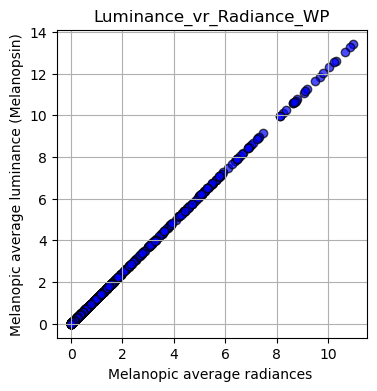

In [33]:
plt.figure(figsize=(4, 4))
plt.scatter(wp_derivatives_alpha_opics_values_df['average_radiances_Melanopsin'], wp_derivatives_alpha_opics_values_df['average_luminance_Melanopsin']
, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Melanopic average radiances ')
plt.ylabel('Melanopic average luminance (Melanopsin)')
plt.title('Luminance_vr_Radiance_WP')
plt.grid(True)

# RMS contrast 

In [34]:
# Normalize using max only

def calculate_rms_contrast(image):
    # Filter out non-finite values (NaN and Inf)
    finite_values = image[np.isfinite(image)]

    # Normalize the finite pixel values between 0 and 1

    max_val = np.max(finite_values)

    # Prevent division by zero if the maximum value is zero
    if max_val > 0:
        normalized_values = finite_values / max_val  # Normalize using max only
    else:
        normalized_values = np.zeros_like(finite_values)  # All values are zero

    # Calculate the mean of the normalized values
    mean_normalized = np.mean(normalized_values)

    # Calculate N (number of valid pixels)
    N = normalized_values.size

    # Calculate RMS contrast using normalized values
    rms_contrast = round(
        np.sqrt(np.sum((normalized_values - mean_normalized)**2) / N), 4)

    return rms_contrast

In [35]:
# Example for WP_derivatve_example_iprgc

rms_contrast_value = calculate_rms_contrast(WP_derivatve_example_iprgc)
rms_contrast_value

0.0809

In [36]:
# Create an empty list to store the results
results = []

# Iterate over each row in the original DataFrame
for index, row in wp_derivatives_df.iterrows():
    file_path = row['file_path']  # Get the file path
    file_name = row['file_name']  # Get the file name
    timestamp = row['timestamp']  # Get the timestamp from the row

    # Load the .npz file
    with np.load(file_path) as npz_file:
        # Get the first 5 keys
        keys = list(npz_file.keys())[:5]

        # Initialize a dictionary to hold the results for this row
        result_dict = {'timestamp': timestamp}  # Include timestamp

        # Iterate over the keys and their new names
        for key, new_name in zip(keys, new_key_names):
            # Extract the array for this key
            array = npz_file[key]

            # Calculate the RMS contrast using the previously defined function
            rms_contrast = calculate_rms_contrast(array)

            # Store the RMS contrast in the dictionary with new name as the column name
            result_dict[f'rms_contrast_{new_name}'] = round(rms_contrast, 4)  # Round to 4 decimal places

        # Append the result dictionary to the results list
        results.append(result_dict)

# Convert the results into a DataFrame for easier merging
rms_contrast_df = pd.DataFrame(results)

In [37]:
rms_contrast_df.head(10)

,timestamp,rms_contrast_L cones,rms_contrast_M cones,rms_contrast_S cones,rms_contrast_Rods,rms_contrast_Melanopsin
0,20230208T0800,0.2034,0.1008,0.0442,0.1940,0.1236
1,20230208T0900,0.3024,0.2642,0.1712,0.3166,0.3019
2,20230208T0930,0.2770,0.2760,0.1932,0.3036,0.2922
3,20230208T1000,0.2948,0.2518,0.1768,0.3154,0.2993
4,20230208T1030,0.2906,0.2429,0.1858,0.3139,0.2980
5,20230208T1100,0.2809,0.2245,0.1678,0.3106,0.2801
6,20230208T1130,0.2688,0.1687,0.1504,0.3038,0.2493
7,20230208T1200,0.2679,0.1551,0.1441,0.3030,0.2388
8,20230208T1230,0.2441,0.1711,0.2017,0.2908,0.2489
9,20230208T1300,0.2157,0.1413,0.2860,0.2775,0.2206


In [38]:
wp_derivatives_alpha_opics_values_df = wp_derivatives_alpha_opics_values_df.merge(
    rms_contrast_df, on='timestamp')
# Set the index starting from 1 and name it "record"
#wp_derivatives_alpha_opics_values_df.index = range(1, len(wp_derivatives_alpha_opics_values_df) + 1)

In [39]:
# Sort the DataFrame by 'rms_contrast_Melanopsin'
sorted_df = wp_derivatives_alpha_opics_values_df.sort_values('rms_contrast_Melanopsin').reset_index(drop=True)

# Number of points to select (e.g., 5 for the example)
num_points = 5

# Calculate step size
step = max(1, len(sorted_df) // (num_points - 1))

# Select indices at equal intervals
selected_indices = [i * step for i in range(num_points)]
# Ensure the last index is included
if selected_indices[-1] >= len(sorted_df):
    selected_indices[-1] = len(sorted_df) - 1

# Print the selected values and three surrounding timestamps
print("Selected RMS Contrast Values and Their Timestamps with Surrounding Timestamps:")
for idx in selected_indices:
    selected_value = sorted_df.loc[idx, 'rms_contrast_Melanopsin']
    # Get three timestamps around the selected index
    start = max(idx - 1, 0)
    end = min(idx + 2, len(sorted_df))
    surrounding_timestamps = sorted_df.loc[start:end-1, 'timestamp'].tolist()
    print(f"RMS Contrast: {selected_value} at Timestamps: {surrounding_timestamps}")


Selected RMS Contrast Values and Their Timestamps with Surrounding Timestamps:
RMS Contrast: 0.0012 at Timestamps: ['20231202T1730', '20231202T1800']
RMS Contrast: 0.0801 at Timestamps: ['20230803T1400', '20230803T1530', '20240311T1600']
RMS Contrast: 0.131 at Timestamps: ['20240319T1600', '20240319T1030', '20230302T1200']
RMS Contrast: 0.2038 at Timestamps: ['20230802T1500', '20240322T1900', '20231019T1230']
RMS Contrast: 0.389 at Timestamps: ['20230414T1030', '20230614T0945']


In [42]:
wp_derivatives_alpha_opics_values_df.shape

(721, 26)

# Load metadata and Jeti

In [50]:
# Read the dataframe from the csv file (jeti_metadata_summary_tidy_scenes.csv)
merged_jeti_metadata_df = pd.read_csv(
    f'{root_dir}\\results\\jeti_metadata_summary_tidy_scenes.csv',
    header=0,
    index_col=0,
    dtype={'time': str})
# Check if each column has any NaN values
columns_with_nan = merged_jeti_metadata_df.isna().any()

# Display columns that have NaN values
columns_with_nan = columns_with_nan[columns_with_nan == True]

print("Columns with NaN values:")
print(columns_with_nan)

Columns with NaN values:
other_weather      True
other_scene        True
other_view         True
other_lighting     True
technotes          True
data_collection    True
dtype: bool


In [51]:
# Replace NaN values with an empty string
merged_jeti_metadata_df = merged_jeti_metadata_df.fillna('')

# Check for NaN values
nan_df = merged_jeti_metadata_df.isna()

# Check if any NaN values exist
if nan_df.any().any():
    print("There are NaN values in the DataFrame.")
else:
    print("There are no NaN values in the DataFrame.")

There are no NaN values in the DataFrame.


In [52]:
merged_jeti_metadata_df.shape

(676, 225)

In [62]:

merged_wp_jeti_metadata_df = pd.merge(wp_derivatives_alpha_opics_values_df, merged_jeti_metadata_df, on='timestamp', how='inner')

Series([], dtype: bool)

In [63]:
# Check for NaN values
nan_df = merged_wp_jeti_metadata_df.isna()

# Check if any NaN values exist
if nan_df.any().any():
    print("There are NaN values in the DataFrame.")
else:
    print("There are no NaN values in the DataFrame.")

There are no NaN values in the DataFrame.


In [64]:
merged_wp_jeti_metadata_df.head()

,timestamp,invalid_pixels_L cones,overexposed_pixels_L cones,average_radiances_L cones,invalid_pixels_M cones,overexposed_pixels_M cones,average_radiances_M cones,invalid_pixels_S cones,overexposed_pixels_S cones,average_radiances_S cones,...,weather,other_weather,scene,other_scene,view,other_view,lighting,other_lighting,technotes,data_collection
record,,,,,,,,,,,,,,,,,,,,,
1,20230208T0800,2712,154712,4.6948,0,46366,3.8895,6776,4539,1.3800,...,Clear-sunny,,Outdoor-countryside,,Outdoor,,Outdoor-daylight,,,2.0
2,20230208T0900,2712,2658410,7.6841,0,238240,11.7963,6776,74539,6.1592,...,Clear-sunny,,Outdoor-countryside,,Outdoor,,Outdoor-daylight,,,2.0
3,20230208T0930,2712,2820669,7.2499,0,345475,12.4157,6776,90147,7.1380,...,Clear-sunny,,Outdoor-countryside,,Outdoor,,Outdoor-daylight,,,2.0
4,20230208T1000,2712,2294105,7.4355,0,108568,11.7486,6776,19786,6.8834,...,Clear-sunny,,Outdoor-countryside,,Outdoor,,Outdoor-daylight,,,2.0
5,20230208T1030,2712,1871378,7.5897,0,17760,11.0070,6776,41,6.5185,...,Clear-sunny,,Outdoor-countryside,,Outdoor,,Outdoor-daylight,,,2.0


In [65]:
merged_wp_jeti_metadata_df.shape

(671, 250)

In [66]:
# Merge the locations "Germany-Tuebingen" and "germany-bad Urach" in the DataFrame
merged_wp_jeti_metadata_df["location"] = merged_wp_jeti_metadata_df["location"].replace("Germany-Bad Urach", "Germany-Tuebingen")

In [67]:
# Define a dictionary with the desired replacements for 'view'

view_mapping = {
    'Outdoor': 'Outdoor view',
    'Indoor-with-glazing': 'Indoor w/ window view',
    'Indoor-interior': 'Indoor w/o window view'
}

# Replace values in the 'view' column in place
merged_wp_jeti_metadata_df['view'] = merged_wp_jeti_metadata_df['view'].replace(view_mapping)

In [68]:
# Define a dictionary with the desired replacements for 'location'

location_mapping = {
    'Germany-Tuebingen': 'Tübingen (Germany)',
    'Canada-Ottawa': 'Ottawa (Canada)',
    'Germany-Munich': 'Munich (Germany)',
    'CzechRepublic-Prague': 'Prague (Czech Republic)',
    'France_Lyon': 'Lyon (France)'
}

# Replace values in the 'location' column in place
merged_wp_jeti_metadata_df['location'] = merged_wp_jeti_metadata_df['location'].replace(location_mapping)

In [69]:
locations = merged_wp_jeti_metadata_df["location"].unique()
locations

array(['Tübingen (Germany)', 'Ottawa (Canada)', 'Munich (Germany)',
       'Prague (Czech Republic)', 'Lyon (France)'], dtype=object)

In [70]:
views = merged_wp_jeti_metadata_df["view"].unique()
views

array(['Outdoor view', 'Indoor w/ window view', 'Indoor w/o window view'],
      dtype=object)

In [71]:
# Save the DataFrame to a CSV file
merged_wp_jeti_metadata_df.to_csv(
    f'{spatial_paper_dir}\\merged_wp_jeti_metadata_df.csv',
    sep=',',
    index=True)

# Calculating correlation for radiances (pixel by pixel)

In [86]:
# Add view column from the metadata to wp_derivatives_df

merged_wp_derivatives_view = pd.merge(wp_derivatives_df,
                                   merged_wp_jeti_metadata_df[['timestamp', 'view']],
                                   on='timestamp',
                                   how='inner')


In [72]:
# Example for one image

# Get the first row of your DataFrame
first_row = wp_derivatives_df.iloc[0]  # Get the first row

# Get the first row of your DataFrame
first_row = wp_derivatives_df.iloc[0]  # Get the first row

file_path = first_row['file_path']

# Load the .npz file
with np.load(file_path) as npz_file:
    # Get the first 5 keys
    keys = list(npz_file.keys())[:5]

    # Initialize a list to hold the images
    images = []

    # Loop through the first 5 keys
    for key in keys:
        # Extract the array for this key (2D image)
        image_array = npz_file[key]

        # Append the image array to the list
        images.append(image_array)

# Initialize a correlation matrix
correlation_matrix = np.zeros((5, 5))

# Calculate pairwise correlation between the images
for i in range(len(images)):
    for j in range(len(images)):
        if i != j:
            # Create masks for valid pixel values (not NaN and not Inf)
            mask_i = np.isfinite(images[i])  # Mask for the i-th image
            mask_j = np.isfinite(images[j])  # Mask for the j-th image

            # Create a combined mask for overlapping pixels
            combined_mask = mask_i & mask_j

            # Get the valid pixels for both images based on the combined mask
            valid_pixels_i = images[i][combined_mask].flatten()
            valid_pixels_j = images[j][combined_mask].flatten()

            # Calculate the correlation only if there are valid pixels
            if len(valid_pixels_i) > 1 and len(valid_pixels_j) > 1:  # Ensure enough valid points to calculate correlation
                correlation_matrix[i, j] = np.corrcoef(valid_pixels_i, valid_pixels_j)[0, 1]
            else:
                correlation_matrix[i, j] = np.nan  # Not enough data to calculate correlation
        else:
            correlation_matrix[i, j] = 1.0  # Correlation with itself is 1

# Create a DataFrame from the correlation matrix for better readability
correlation_df = pd.DataFrame(correlation_matrix, index=new_key_names, columns=new_key_names)


In [73]:
correlation_df 


,L cones,M cones,S cones,Rods,Melanopsin
L cones,1.000000,0.992393,0.864592,0.967213,0.951441
M cones,0.992393,1.000000,0.870333,0.981512,0.960327
S cones,0.864592,0.870333,1.000000,0.952929,0.941134
Rods,0.967213,0.981512,0.952929,1.000000,0.997083
Melanopsin,0.951441,0.960327,0.941134,0.997083,1.000000


In [89]:
# Pixel by pixel correlations 

# Initialize an average correlation matrix
average_correlation_matrix = np.zeros((5, 5))
count_valid_files = 0  # To count how many valid .npz files were processed

# Iterate over each row in the DataFrame
for index, row in merged_wp_derivatives_view.iterrows():
    file_path = row['file_path']

    # Load the .npz file
    with np.load(file_path) as npz_file:
        # Get the first 5 keys
        keys = list(npz_file.keys())[:5]

        # Initialize a list to hold the images
        images = []

        # Loop through the first 5 keys
        for key in keys:
            # Extract the array for this key (2D image)
            image_array = npz_file[key]
            images.append(image_array)

        # Initialize a correlation matrix for this file
        correlation_matrix = np.zeros((5, 5))

        # Calculate pairwise correlation between the images
        for i in range(len(images)):
            for j in range(len(images)):
                if i != j:
                    # Create masks for valid pixel values (not NaN and not Inf)
                    mask_i = np.isfinite(images[i])  # Mask for the i-th image
                    mask_j = np.isfinite(images[j])  # Mask for the j-th image

                    # Create a combined mask for overlapping pixels
                    combined_mask = mask_i & mask_j

                    # Get the valid pixels for both images based on the combined mask
                    valid_pixels_i = images[i][combined_mask].flatten()
                    valid_pixels_j = images[j][combined_mask].flatten()

                    # Calculate the correlation only if there are valid pixels
                    if len(valid_pixels_i) > 1 and len(valid_pixels_j) > 1:  # Ensure enough valid points to calculate correlation
                        correlation_matrix[i, j] = np.corrcoef(valid_pixels_i, valid_pixels_j)[0, 1]
                    else:
                        correlation_matrix[i, j] = np.nan  # Not enough data to calculate correlation
                else:
                    correlation_matrix[i, j] = 1.0  # Correlation with itself is 1

        # Update the average correlation matrix while skipping NaN values
        count_valid_files += 1
        average_correlation_matrix += correlation_matrix

# Calculate the average correlation by dividing by the number of valid files processed
if count_valid_files > 0:
    average_correlation_matrix /= count_valid_files

# Create a DataFrame from the average correlation matrix for better readability
average_correlation_df = pd.DataFrame(average_correlation_matrix, index=new_key_names, columns=new_key_names)


In [88]:
average_correlation_df 

,L cones,M cones,S cones,Rods,Melanopsin
L cones,1.000000,0.980558,0.945898,0.975743,0.966344
M cones,0.980558,1.000000,0.958452,0.971377,0.969232
S cones,0.945898,0.958452,1.000000,0.969892,0.973113
Rods,0.975743,0.971377,0.969892,1.000000,0.984489
Melanopsin,0.966344,0.969232,0.973113,0.984489,1.000000


In [90]:
# Pixel by pixel correlations for each 'View'

# Initialize dictionary to store correlation matrices by view category
average_correlation_matrices = {}
count_valid_files_by_view = {}

# Unique view categories
view_categories = merged_wp_derivatives_view["view"].unique()

# Initialize matrices and counters for each view category
for view in view_categories:
    average_correlation_matrices[view] = np.zeros((5, 5))
    count_valid_files_by_view[view] = 0

# Iterate over each row in the DataFrame
for index, row in merged_wp_derivatives_view.iterrows():
    file_path = row['file_path']
    view_category = row['view']  # Current view category for this file

    with np.load(file_path) as npz_file:
        keys = list(npz_file.keys())[:5]
        images = [npz_file[key] for key in keys]

        correlation_matrix = np.zeros((5, 5))

        for i in range(len(images)):
            for j in range(len(images)):
                if i != j:
                    mask_i = np.isfinite(images[i])
                    mask_j = np.isfinite(images[j])
                    combined_mask = mask_i & mask_j

                    valid_pixels_i = images[i][combined_mask].flatten()
                    valid_pixels_j = images[j][combined_mask].flatten()

                    if len(valid_pixels_i) > 1 and len(valid_pixels_j) > 1:
                        correlation_matrix[i, j] = np.corrcoef(valid_pixels_i, valid_pixels_j)[0, 1]
                    else:
                        correlation_matrix[i, j] = np.nan
                else:
                    correlation_matrix[i, j] = 1.0

 # Update average matrix for this view, skipping NaN
        count_valid_files_by_view[view_category] += 1
        average_correlation_matrices[view_category] += correlation_matrix

# Final averaging
average_correlation_dfs = {}
for view, matrix in average_correlation_matrices.items():
    if count_valid_files_by_view[view] > 0:
        matrix /= count_valid_files_by_view[view]
    # Convert each to a DataFrame for readability
    average_correlation_dfs[view] = pd.DataFrame(matrix, index=new_key_names, columns=new_key_names)

In [91]:
# Flatten the dictionary into a long-format DataFrame
long_format = []
for category, df in average_correlation_dfs.items():
    melted_df = df.reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
    melted_df['view'] = view_mapping.get(category, category)
    long_format.append(melted_df)

long_format_df = pd.concat(long_format)
long_format_df.rename(columns={'index': 'Row'}, inplace=True)

In [92]:
long_format_df.to_csv(
    f'{spatial_paper_dir}\\average_pixels_correlation_df.csv',
    sep=',', index=False)

# Amplitude spectra analysis

In [93]:
# Input: 2D Numpy array, Output: 2D Numpy array

# Function to compute the amplitude spectrum
def compute_amplitude_spectrum(image):
    # Get dimensions of the input image
    height, width = image.shape
    # Determine the shorter dimension
    min_dim = min(height, width)
    
    # Crop the image to a centered square patch
    start_x = (width - min_dim) // 2
    start_y = (height - min_dim) // 2
    cropped_image = image[start_y:start_y + min_dim, start_x:start_x + min_dim]
    
    # Compute the median of valid values (ignoring NaN and Inf)
    valid_median = np.nanmedian(cropped_image)
    # Compute the maximum value (ignoring NaN and Inf)
    valid_max = np.nanmax(cropped_image[np.isfinite(cropped_image)])
    # Replace NaN with the computed median
    cropped_image = np.where(np.isnan(cropped_image), valid_median, cropped_image)
    # Replace Inf with the computed maximum value
    cropped_image = np.where(np.isinf(cropped_image), valid_max, cropped_image)
    
    # Perform 2D FFT on the valid part of the image (ignores NaN and Inf values)
    fft_result = fft2(cropped_image)
    fft_result = fftshift(fft_result)  # Shift the zero frequency component to the center
    amplitude_spectrum = np.abs(fft_result)
    return amplitude_spectrum



In [95]:
amp_spec_iprgc = compute_amplitude_spectrum(WP_derivatve_example_iprgc)


In [94]:
## Input: 2D Numpy array, Outputs: 1D Numpy array

def radial_frequencies_logarithmically_spaced(amplitude_spectrum, center=None, num_log_bins=100):
    

    # Create coordinate grids
    y, x = np.indices(amplitude_spectrum.shape)
    if center is None:
        center = (amplitude_spectrum.shape[1] // 2, amplitude_spectrum.shape[0] // 2)

    # Calculate radial distances from the center
    radial_distances = np.sqrt((x - center[0])**2 + (y - center[1])**2)

# Determine logarithmically spaced bins for radial distances
    min_distance = np.min(radial_distances[radial_distances > 0])  # Exclude zero
    max_distance = np.max(radial_distances)
    log_bins = np.logspace(np.log10(min_distance), np.log10(max_distance), num=num_log_bins + 1)

    # Compute radial bins and their average values (exclude zero frequency)
    radial_amplitude, _ = np.histogram(radial_distances,
                                       bins=log_bins,
                                       weights=amplitude_spectrum)

    # Normalize by the number of points in each bin
    counts, _ = np.histogram(radial_distances, bins=log_bins)
    radial_amplitude = radial_amplitude / (counts + 1e-10)  # Avoid division by zero

    # Radial frequencies correspond to bin centers
    radial_frequencies = np.sqrt(log_bins[:-1] * log_bins[1:])
    
    # Filter out zero or near-zero amplitudes and frequencies above 10^2
    valid_indices = (radial_amplitude > 1e-10) & (radial_frequencies <= 10**2)
    radial_frequencies = radial_frequencies[valid_indices]
    radial_amplitude = radial_amplitude[valid_indices]

    return radial_frequencies, radial_amplitude

In [96]:
# Calculate radial average
frequencies, amplitudes = radial_frequencies_logarithmically_spaced(amp_spec_iprgc)


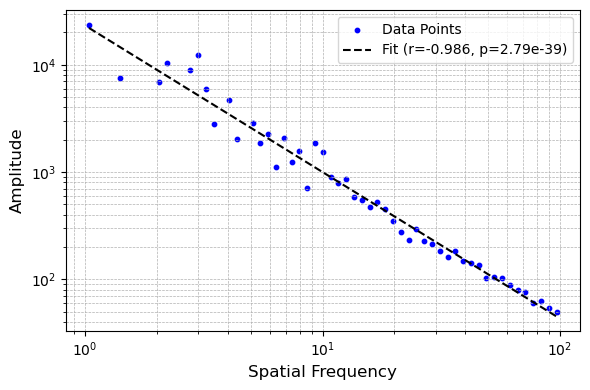

In [99]:

# Perform linear regression on the log-log scale
log_frequencies = np.log10(frequencies)
log_amplitudes = np.log10(amplitudes)
slope, intercept, r_value, p_value, std_err = linregress(log_frequencies, log_amplitudes)

# Generate the regression line
fitted_amplitudes = (10 ** intercept) * (frequencies ** slope)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(frequencies, amplitudes, color='blue', s=10, label='Data Points')  # Scatter plot
ax.plot(frequencies, fitted_amplitudes, label=f"Fit (r={r_value:.3f}, p={p_value:.2e})", 
            linestyle='--', color='black', linewidth=1.5)  # Regression line

# Log-log scale and formatting
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Spatial Frequency", fontsize=12)
ax.set_ylabel("Amplitude", fontsize=12)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend(fontsize=10)
plt.tight_layout()    

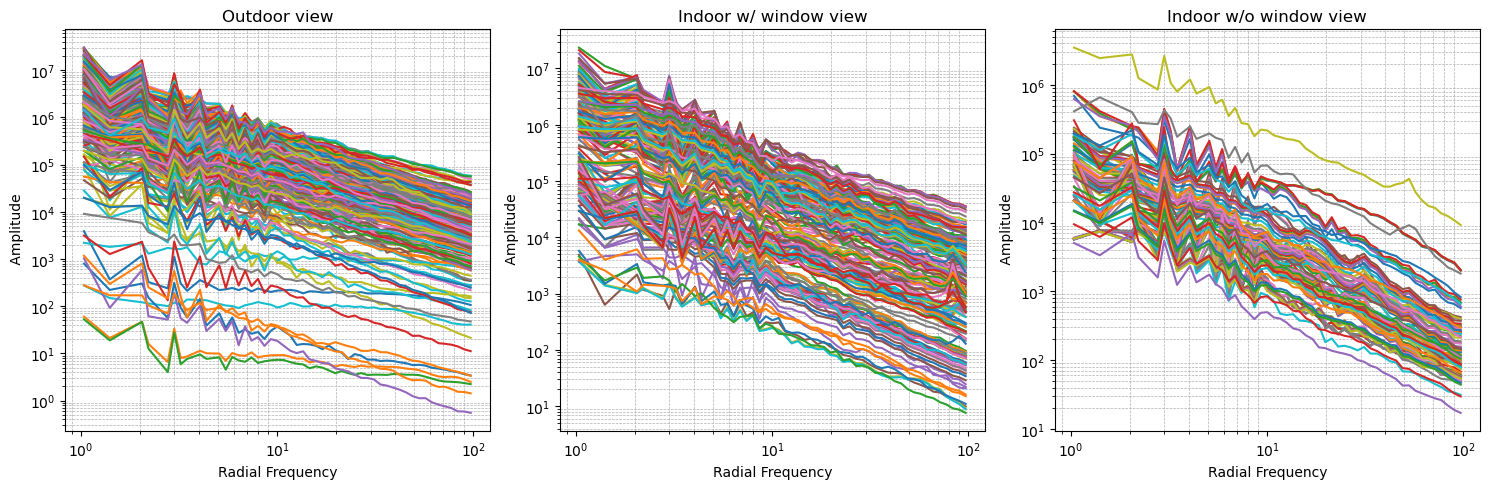

In [100]:


# Initialize a dictionary to store amplitude spectra for each view category

radial_data_by_view = {}

# Iterate over each row in the DataFrame
for index, row in merged_wp_derivatives_view.iterrows():
    file_path = row['file_path']
    view_category = row['view']  # Current view category for this file

    with np.load(file_path) as npz_file:
        # Ensure there are at least 5 keys in the npz file
        keys = list(npz_file.keys())
        if len(keys) >= 5:  # Check if there are 5 or more items
            key = keys[4]  # Get the fifth key (iprgc)
            iprgc_array = npz_file[key]  # Load the corresponding array

            # Compute the amplitude spectrum for this array using the provided function
            amplitude_spectrum = compute_amplitude_spectrum(iprgc_array)

            # Compute radial frequencies and radial amplitude using the radial_frequencies function
            radial_frequencies_vals, radial_amplitude_vals = radial_frequencies_logarithmically_spaced(amplitude_spectrum)

            # Store radial frequencies and radial amplitudes for each view category
            if view_category not in radial_data_by_view:
                radial_data_by_view[view_category] = {
                    'frequencies': [],
                    'amplitudes': []
                }

            # Append the radial frequencies and amplitudes for the current image
            radial_data_by_view[view_category]['frequencies'].append(radial_frequencies_vals)
            radial_data_by_view[view_category]['amplitudes'].append(radial_amplitude_vals)

# Now let's plot the radial amplitudes vs radial frequencies for each view category
num_views = len(views)  # Number of view categories
fig, axes = plt.subplots(nrows=1, ncols=num_views, figsize=(15, 5))

# In case there's only one view category, ensure axes is iterable
if num_views == 1:
    axes = [axes]

for ax, view_category in zip(axes, views):
    # For each view category, plot all the radial amplitudes against the frequencies
    for freqs, amplitudes in zip(radial_data_by_view[view_category]['frequencies'], 
                                  radial_data_by_view[view_category]['amplitudes']):
        ax.plot(freqs, amplitudes)

    # Set labels and title for each subplot
    ax.set_xlabel('Radial Frequency')
    ax.set_ylabel(' Amplitude')
    ax.set_xscale('log')  # Optional: for better visualization
    ax.set_yscale('log')  # Optional: for better visualization
    ax.set_title(view_category)
    ax.grid(True, which='minor', linestyle='--', linewidth=0.5)

# Adjust the layout for better spacing
plt.tight_layout()
plt.savefig( f'{spatial_paper_dir}\\All_amplitude)spectra_per_view.png', dpi=600, bbox_inches='tight')

In [101]:
# Initialize dictionaries to store slopes and per-category min/max
slopes_by_view = {view: [] for view in views}
per_view_min_max = {
    view: {
        'min': np.inf,
        'max': -np.inf,
        'min_timestamp': None,
        'max_timestamp': None
    } for view in views
}  # Store min/max and timestamps for each category

# General min/max values
max_slope = -np.inf
min_slope = np.inf
max_slope_timestamp = None
min_slope_timestamp = None

# Iterate over each row in the DataFrame
for index, row in merged_wp_derivatives_view.iterrows():
    file_path = row['file_path']
    view_category = row['view']
    timestamp = row['timestamp']

    with np.load(file_path) as npz_file:
        # Ensure there are at least 5 keys in the npz file
        keys = list(npz_file.keys())
        if len(keys) >= 5:  # Check if there are 5 or more items
            key = keys[4]  # Get the fifth key (iprgc)
            iprgc_array = npz_file[key]  # Load the corresponding array

            # Compute the amplitude spectrum for this array using the provided function
            amplitude_spectrum = compute_amplitude_spectrum(iprgc_array)

            # Compute radial frequencies and radial amplitude using the radial_frequencies function
            radial_frequencies_vals, radial_amplitude_vals = radial_frequencies_logarithmically_spaced(amplitude_spectrum)
            
            # Perform linear regression on log-log data
            log_frequencies = np.log10(radial_frequencies_vals)
            log_amplitudes = np.log10(radial_amplitude_vals)
            
            # Perform linear fit (log-log scale)
            slope, intercept, r_value, p_value, std_err = linregress(log_frequencies, log_amplitudes)

            # Calculate absolute value of the slope for general min/max comparison
            abs_slope = abs(slope)

            # Update general min/max slopes
            if abs_slope > max_slope:
                max_slope = abs_slope
                max_slope_timestamp = timestamp  # Store the timestamp of max slope

            if abs_slope < min_slope:
                min_slope = abs_slope
                min_slope_timestamp = timestamp  # Store the timestamp of min slope

            # Store the slope for the current view category
            slopes_by_view[view_category].append(slope)

            # Update per-view min/max slopes and timestamps
            if abs_slope < per_view_min_max[view_category]['min']:
                per_view_min_max[view_category]['min'] = abs_slope
                per_view_min_max[view_category]['min_timestamp'] = timestamp

            if abs_slope > per_view_min_max[view_category]['max']:
                per_view_min_max[view_category]['max'] = abs_slope
                per_view_min_max[view_category]['max_timestamp'] = timestamp

# Print or return results as needed
print("General Max Slope:", max_slope, "at timestamp", max_slope_timestamp)
print("General Min Slope:", min_slope, "at timestamp", min_slope_timestamp)

for view, stats in per_view_min_max.items():
    print(f"View '{view}': Min Slope = {stats['min']} at timestamp {stats['min_timestamp']}, "
          f"Max Slope = {stats['max']} at timestamp {stats['max_timestamp']}")

General Max Slope: 1.7401402144449543 at timestamp 20230619T0900
General Min Slope: 0.20099651727459292 at timestamp 20230622T2130
View 'Outdoor view': Min Slope = 0.20099651727459292 at timestamp 20230622T2130, Max Slope = 1.7401402144449543 at timestamp 20230619T0900
View 'Indoor w/ window view': Min Slope = 0.9565307588310842 at timestamp 20231114T1700, Max Slope = 1.6173118210848931 at timestamp 20240109T1130
View 'Indoor w/o window view': Min Slope = 0.8531281815506286 at timestamp 20230626T1530, Max Slope = 1.5541523839358857 at timestamp 20230613T1400


In [102]:
# Initialize dictionaries to store slopes and regression parameters for each view category
regression_by_view = {view: {'slope': [], 'r_value': [], 'p_value': [], 'std_err': [], 'timestamp': []} for view in views}



# Iterate over each row in the DataFrame
for index, row in merged_wp_derivatives_view.iterrows():
    file_path = row['file_path']
    view_category = row['view']
    timestamp = row['timestamp']

    with np.load(file_path) as npz_file:
        # Ensure there are at least 5 keys in the npz file
        keys = list(npz_file.keys())
        if len(keys) >= 5:  # Check if there are 5 or more items
            key = keys[4]  # Get the fifth key (iprgc)
            iprgc_array = npz_file[key]  # Load the corresponding array

            # Compute the amplitude spectrum for this array using the provided function
            amplitude_spectrum = compute_amplitude_spectrum(iprgc_array)

            # Compute radial frequencies and radial amplitude using the radial_frequencies function
            radial_frequencies_vals, radial_amplitude_vals = radial_frequencies_logarithmically_spaced(amplitude_spectrum)

            # Perform linear regression on log-log data
            log_frequencies = np.log10(radial_frequencies_vals)
            log_amplitudes = np.log10(radial_amplitude_vals)

            # Perform linear fit (log-log scale)
            slope, intercept, r_value, p_value, std_err = linregress(log_frequencies, log_amplitudes)

            # Append the regression values for the current view category
            regression_by_view[view_category]['slope'].append(slope)
            regression_by_view[view_category]['r_value'].append(r_value)
            regression_by_view[view_category]['p_value'].append(p_value)
            regression_by_view[view_category]['std_err'].append(std_err)
            regression_by_view[view_category]['timestamp'].append(timestamp)




In [103]:
# Initialize an empty list to hold the rows for the DataFrame
df_rows = []

# Find the maximum number of entries for any view (to align rows properly)
max_entries = max(len(v['slope']) for v in regression_by_view.values())

# Iterate through all possible indices
for i in range(max_entries):
    # Create a dictionary to hold the values for this row
    row_data = {}
    
    # Loop through each view and add the values to the row_data dictionary
    for view, values in regression_by_view.items():
        # Ensure all views have the same number of rows, fill with NaN if necessary
        row_data[f'slope_{view}'] = values['slope'][i] if i < len(values['slope']) else float('nan')
        row_data[f'r_value_{view}'] = values['r_value'][i] if i < len(values['r_value']) else float('nan')
        row_data[f'p_value_{view}'] = values['p_value'][i] if i < len(values['p_value']) else float('nan')
        row_data[f'std_err_{view}'] = values['std_err'][i] if i < len(values['std_err']) else float('nan')
        row_data[f'timestamp_{view}'] = values['timestamp'][i] if i < len(values['timestamp']) else float('nan')

    # Append the row data to the list
    df_rows.append(row_data)

# Convert the list of rows into a DataFrame
regression_df = pd.DataFrame(df_rows)


In [104]:
regression_df.head()

,slope_Outdoor view,r_value_Outdoor view,p_value_Outdoor view,std_err_Outdoor view,timestamp_Outdoor view,slope_Indoor w/ window view,r_value_Indoor w/ window view,p_value_Indoor w/ window view,std_err_Indoor w/ window view,timestamp_Indoor w/ window view,slope_Indoor w/o window view,r_value_Indoor w/o window view,p_value_Indoor w/o window view,std_err_Indoor w/o window view,timestamp_Indoor w/o window view
0,-1.482937,-0.987556,3.181121e-40,0.034086,20230208T0800,-1.123225,-0.987859,1.769766e-40,0.025496,20230310T0800,-1.539778,-0.987227,5.939593e-40,0.035867,20230404T1030
1,-1.430684,-0.980685,1.128222e-35,0.041186,20230208T0900,-1.149777,-0.985653,9.478916e-39,0.028418,20230310T0830,-1.551757,-0.986582,1.922580e-39,0.037066,20230404T1100
2,-1.446821,-0.981908,2.378185e-36,0.040272,20230208T0930,-1.176681,-0.987464,3.793797e-40,0.027148,20230310T0900,-1.542314,-0.985124,2.248892e-38,0.038833,20230404T1130
3,-1.511422,-0.983934,1.406927e-37,0.039584,20230208T1000,-1.153312,-0.984965,2.898748e-38,0.029197,20230310T0930,-1.531387,-0.984098,1.101605e-37,0.039896,20230404T1200
4,-1.552161,-0.984029,1.221771e-37,0.040528,20230208T1030,-1.100609,-0.985813,7.264637e-39,0.027048,20230310T1000,-1.546493,-0.985594,1.045669e-38,0.038304,20230404T1230


In [105]:
# Save to a CSV file
regression_df.to_csv(f'{spatial_paper_dir}\\amplitude_spectra_regression_view_df.csv',
    sep=',', index=False)